In [12]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import datetime
import random
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.stats import random_correlation
import scipy.optimize as optimize
import scipy.interpolate as sci
import time
import tqdm

import import_ipynb

import tensorflow as tf
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, SparkTrials, space_eval
from hyperopt import rand
import sys
import math

# Data

In [13]:
class Data:
    def __init__(self, seed, size, data_len,n_past, train_size):
        self.seed = seed
        self.size = size
        self.data_len = data_len
        self.cov = None
        self.pi_matrix = None
        self.price_series = []
        self.expected_returns = []
        self.actual_returns = []
        self.n_past = n_past
        self.train_size = train_size
        self.mu = None
        self.sd_low, self.sd_high, self.eig_low, self.eig_high = 0.008, 0.02, -0.3, 0.3

    def set_random_cov(self):    
        np.random.seed(self.seed)
        eigen = np.random.dirichlet(np.ones(self.size), size=1)[0]*self.size
        C = random_correlation.rvs(eigen, random_state=self.seed)
        D = np.diag(np.random.uniform(low=self.sd_low, high=self.sd_high, size=(1, self.size))[0])
        self.cov = D @ C @ D

    def get_cov(self):
        return self.cov

    def set_random_pi_matrix(self):
        np.random.seed(self.seed)
        L = np.diag(np.random.uniform(low=self.eig_low, high=self.eig_high, size=(1, self.size))[0])
        M = np.random.rand(self.size, self.size)
        U, S, Vh = np.linalg.svd(M, full_matrices=False)
        R = U @ Vh
        self.pi_matrix = R @ L @ R.T

    def get_pi_matrix(self):
        return self.pi_matrix

    def generate_data(self):
        self.set_random_cov()
        self.set_random_pi_matrix()
        self.price_series = np.empty([0, self.size])
        self.actual_returns = np.empty([0, self.size])
        self.expected_returns = np.empty([0, self.size])
        prices = np.random.uniform(low=100, high=200, size=(1, self.size))[0]
        self.price_series = np.vstack([self.price_series,prices])
        returns = np.random.uniform(low=-0.005, high=0.02, size=(1, self.size))[0]
        self.actual_returns = np.vstack([self.actual_returns, returns])
        self.mu = np.random.uniform(low=-0.0002, high=0.0004,size=(1, self.size))[0]
        self.c = np.dot(np.eye(self.size)-self.pi_matrix,self.mu)

        for i in range(self.data_len):
            noise = np.random.multivariate_normal(np.zeros_like(returns), self.cov)
            self.expected_returns = np.vstack([self.expected_returns, self.pi_matrix @ returns + self.c])
            returns = self.expected_returns[-1] + noise
            self.actual_returns = np.vstack([self.actual_returns, returns])
            prices = prices + prices * returns
            self.price_series = np.vstack([self.price_series, prices])
        return self.price_series, self.cov, self.expected_returns, self.actual_returns, self.mu

    def split_series(self,ps, acr):

        X, y = list(), list()
        for window_start in range(ps.shape[0]):
            past_end = window_start + self.n_past
            future_end = past_end + 1
            if future_end > ps.shape[0]:
                break
            # slicing the past and future parts of the window
            past, future = ps[window_start:past_end, :], acr[past_end, :]
            X.append(past)
            y.append(future)
        return np.array(X),np.array(y)

    def get_train_test_data(self, normalize=True, return_data = False):
        self.price_series_train, self.price_series_valid, self.actual_returns_train, self.actual_returns_valid = train_test_split(self.price_series,self.actual_returns, test_size = 0.3, shuffle=False)
        self.price_series_valid, self.price_series_test, self.actual_returns_valid, self.actual_returns_test = train_test_split(self.price_series_valid,self.actual_returns_valid, test_size = 0.5, shuffle=False)
        if normalize:
            self.standardize()
            self.X_train, self.y_train = self.split_series(self.price_series_train, self.actual_returns_train)
            self.X_valid, self.y_valid = self.split_series(self.price_series_valid, self.actual_returns_valid)
            self.X_test, self.y_test = self.split_series(self.price_series_test, self.actual_returns_test)
            return self.X_train, self.X_valid, self.X_test, self.y_train, self.y_valid, self.y_test
        if return_data:
            self.X_train, self.y_train = self.split_series(self.price_series_train, self.actual_returns_train)
            self.X_valid, self.y_valid = self.split_series(self.price_series_valid, self.actual_returns_valid)
            self.X_test, self.y_test = self.split_series(self.price_series_test, self.actual_returns_test)
            self.convert_return_data()
            return self.X_train, self.X_valid, self.X_test, self.y_train, self.y_valid, self.y_test
        else:
            self.X_train, self.y_train = self.split_series(self.price_series_train, self.actual_returns_train)
            self.X_valid, self.y_valid = self.split_series(self.price_series_valid, self.actual_returns_valid)
            self.X_test, self.y_test = self.split_series(self.price_series_test, self.actual_returns_test)
            return self.X_train, self.X_valid, self.X_test, self.y_train, self.y_valid, self.y_test

    def get_train_valid(self):
        self.X_train_valid, self.y_train_valid = np.vstack((self.X_train, self.X_valid)), np.vstack((self.y_train, self.y_valid))
        return self.X_train_valid, self.y_train_valid

    def plot_data(self, ax):
        for i in range(self.price_series.shape[1]):
            ax.plot(self.price_series[:,i],label=f'Stock {i+1}')
        ax.legend(loc='upper left', fontsize=8)
    
    def plot_dataex(self):
        fig = px.line(self.price_series, x='year', y='price')
        fig.show()

    def standardize(self):
        scaler = StandardScaler()
        self.price_series_train = scaler.fit_transform(self.price_series_train)
        self.price_series_valid = scaler.transform(self.price_series_valid)
        self.price_series_test = scaler.transform(self.price_series_test)

    def convert_return_data(self):
        self.X_train, self.X_valid, self.X_test = self.y_train[:-1].copy(), self.y_valid[:-1].copy(), self.y_test[:-1].copy()
        self.y_train, self.y_valid, self.y_test = self.y_train[1:], self.y_valid[1:], self.y_test[1:]
        self.X_train, self.y_train = self.split_series(self.X_train,self.y_train)
        self.X_valid, self.y_valid = self.split_series(self.X_valid,self.y_valid)
        self.X_test, self.y_test = self.split_series(self.X_test,self.y_test)

    def information(self):
        return {'seed': self.seed, 'data_len': self.data_len, 'size': self.size, 'n_past': self.n_past, 'eig': str(self.eig_low) + ':' + str(self.eig_high), 'sd': str(self.sd_low) + ':' + str(self.sd_high)}

    def calc_unconditional_cov(self):
        return np.dot(np.dot(np.linalg.inv(np.eye(self.size)-self.pi_matrix),self.cov),np.linalg.inv(np.eye(self.size)-np.transpose(self.pi_matrix)))

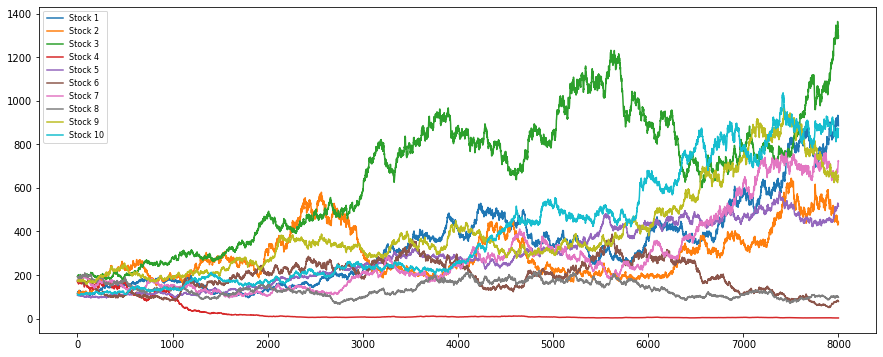

In [14]:
data = Data(seed=1, size=10, data_len=8000, n_past=10, train_size=0.8)
price_series, cov, expected_returns, actual_returns, mu = data.generate_data()
X_train, X_valid, X_test, y_train, y_valid, y_test = data.get_train_test_data(normalize=False)
X_train_valid, y_train_valid = data.get_train_valid()
unc_cov = data.calc_unconditional_cov()
fig, ax = plt.subplots(1, figsize=(15, 6))
data.plot_data(ax=ax)

# Markowitz

In [15]:
def x_gmv(cov):
    size = cov.shape[0]
    ones = np.ones(size)
    c = ones.T @ np.linalg.inv(cov) @ ones
    return (1/c) * (np.linalg.inv(cov) @ ones)

def mu_gmv(cov, expected_return):
    A = calc_A(cov, expected_return)
    return A[0,1]/A[1,1]

def calc_A(cov,expected_return):
    size = cov.shape[0]
    A = np.vstack([expected_return.T,np.ones(size)]) @ np.linalg.inv(cov)
    temp = np.vstack([expected_return.T,np.ones(size)]).T
    return np.dot(A,temp)

def x_opt(cov,expected_return,mu):
    size = cov.shape[0]
    A = calc_A(cov,expected_return)
    temp = np.dot(np.linalg.inv(cov), np.vstack([expected_return.T,np.ones(size)]).T)
    temp = np.dot(temp, np.linalg.inv(A)) @ np.array([mu,1])
    return temp

def sigma_opt(mu,cov,expected_return):
    A = calc_A(cov,expected_return)
    return np.array([[mu],[1]]).T @ np.linalg.inv(A) @ np.array([mu,1])

def x_tan(cov, expected_return):
    size = cov.shape[0]
    ones = np.ones(size)
    Si = np.linalg.inv(cov)

    denom = expected_return.T @ Si @ ones
    return (1/denom) * Si @ expected_return

def mu_tan(cov, expected_return):
    size = cov.shape[0]
    ones = np.ones(size)
    Si = np.linalg.inv(cov)
    
    numer = expected_return.T @ Si @ expected_return
    denom = expected_return.T @ Si @ ones
    return numer/denom

def x_sharpe(cov, expected_return):
    A = calc_A(cov, expected_return)
    mu_opt = np.sqrt(A[0,0]/A[1,1])
    return x_opt(cov, expected_return, mu_opt)
    
def sharpe(rets):
    total_ret = tf.reduce_prod(1 + rets) - 1
    return float(total_ret/np.std(rets))

def sortino(rets):
    neg_rets = rets[rets<0]
    total_ret = tf.reduce_prod(1 + rets) - 1
    return float(total_ret / np.std(neg_rets))

# Reinforcement Learning

## Helper functions to the Trainer Class

In [17]:
def custom_loss(y_true,y_pred):
        returns = tf.reduce_sum(y_true * y_pred)
        return -tf.math.log(1+returns)

def _train(model, space, X_train, y_train, X_valid=None, y_valid=None, opt='return', validation=True, verbose=False):
    model.compile(loss=space['loss_fn'], optimizer=tf.keras.optimizers.SGD(learning_rate=space['lr'], momentum=space['momentum'], nesterov=space['nesterov']))
    if verbose:
        print ('Params testing: ', space)
        model.summary()

    if not validation:
        history = model.fit(X_train, y_train, epochs=150, batch_size = space['batch_size'], verbose=0)
        return history
    else:
        history = model.fit(X_train, y_train, epochs=150, batch_size = space['batch_size'], validation_data=(X_valid, y_valid), verbose=0)

        preds = model.predict(X_valid)
        model_rets = np.array(tf.reduce_sum(preds * y_valid, axis=1))

        if opt == 'return':
            performance = -(tf.reduce_prod(1 + model_rets, axis=0) - 1)
        elif opt == 'sharpe':
            performance = -sharpe(model_rets)
        else:
            performance = - sortino(model_rets)
        return performance, history
    

## Trainer classes with built-in hyperparameter tuning

In [18]:
class Trainer:
    def __init__(self, space, data, opt, normalize, return_data):
        self.space = space
        self.X_train, self.X_valid, self.X_test, self.y_train, self.y_valid, self.y_test = data.get_train_test_data(normalize,return_data)
        self.X_train_valid, self.y_train_valid = data.get_train_valid()
        if normalize:
            self.data_type = 'norm'
        if return_data:
            self.data_type = 'ret'
        else:
            self.data_type = 'raw'
            
        self.current_best = math.inf
        self.opt = opt
        self.normalize = normalize
        self.return_data = return_data
        self.nn_type = ''

    def get_model(self, space, load=False):
        pass

    def save_weights(self, model):
        model.save_weights(f'Trained Models/{self.nn_type}_{self.data_type}_{self.opt}')

    def train(self, space, load=False):        
        model = self.get_model(space, load)

        performance, history = _train(model, space, self.X_train, self.y_train, self.X_valid, self.y_valid, self.opt, validation=True)

        if performance < self.current_best:
            self.current_best = performance
            model.save_weights(f'Trained Models/{self.nn_type}')
            pd.DataFrame.from_dict({'Param':space.keys(), 'Value':space.values()}).to_csv(f'Trained Models/{self.nn_type}.csv', index=False, sep=';')
            with open(f'{self.nn_type}_best.txt', 'w') as f:
                f.write(str(float(self.current_best)))

        sys.stdout.flush()
        return {
            'loss': performance,
            'status': STATUS_OK,
            'model': model,
            'history': history,
            }

    def tune(self, max_evals):
        trials = Trials()
        best = fmin(
            fn=self.train,
            space=self.space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials
            )
        hyperparams = space_eval(self.space, best)
        model = self.get_model(hyperparams)
        history_valid = _train(model, hyperparams, self.X_train_valid, self.y_train_valid, validation=False)
        history = trials.best_trial['result']['history']
        time = datetime.datetime.now().strftime('%d_%H_%M')
        model.save_weights(f'Trained Models/{self.nn_type}_{self.data_type}_{self.opt}_{time}')
        return {
            'Hyperparams': hyperparams,
            'Opt': self.opt,
            'Normalize': self.normalize,
            'Return_data': self.return_data,
            'data': data.information(),
            'time': time,
            'Test preds': test_preds,
            'History': history
        }
        

In [19]:
class CNNTrainer(Trainer):
    def __init__(self, space, data, opt, normalize=True, return_data=False):
        super().__init__(space, data, opt, normalize, return_data)

        self.X_train = self.X_train.reshape((self.X_train.shape[0], self.X_train.shape[1], self.X_train.shape[2], 1))
        self.X_valid = self.X_valid.reshape((self.X_valid.shape[0], self.X_valid.shape[1], self.X_valid.shape[2], 1))
        self.X_test = self.X_test.reshape((self.X_test.shape[0], self.X_test.shape[1], self.X_test.shape[2], 1))
        self.X_train_valid = self.X_train_valid.reshape((self.X_train_valid.shape[0], self.X_train_valid.shape[1], self.X_train_valid.shape[2], 1))
        

        self.nn_type = 'CNN'

    def get_model(self, space, load=False):
        if load:
            df_model = pd.read_csv('Trained Models/CNN.csv',sep=';')
            space = pd.Series(df_model.Value.values, index=df_model.Param).to_dict()
        
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.X_train.shape[1], self.X_train.shape[2], 1)),
            tf.keras.layers.Conv2D(space['Nodes1'], (int(space['filter1_size1']), int(space['filter1_size2'])), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(space['Reg1'])),
            tf.keras.layers.MaxPooling2D((2,2), strides=2),
            tf.keras.layers.Conv2D(space['Nodes2'], (int(space['filter2_size1']), int(space['filter2_size2'])), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(space['Reg2'])),
            tf.keras.layers.MaxPooling2D((2,2), strides=2),
            tf.keras.layers.Conv2D(space['Nodes3'], (int(space['filter3_size1']), int(space['filter3_size2'])), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(space['Reg3'])),
            tf.keras.layers.MaxPooling2D((2,2), strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(space['Nodes4'], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(space['Reg4'])),
            tf.keras.layers.Dropout(rate=space['dropout']),
            tf.keras.layers.Dense(data.size, activation="softmax")
        ])
        if load:
            model.load_weights('Trained Models/CNN')
            with open('CNN_best.txt') as f:
                self.current_best = f.read()
        return model

class LSTMTrainer(Trainer):
    
    def __init__(self, space, data, opt, normalize, return_data):
        super().__init__(space, data, opt, normalize, return_data)
        self.nn_type = 'LSTM'

    def get_model(self, space,load = False):
        if load:
            df_model = pd.read_csv('Trained Models/LSTM.csv', sep=';')
            space = pd.Series(df_model.Value.values, index=df_model.Param).to_dict()
        
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(data.n_past, data.size)),
            tf.keras.layers.LSTM(space['Nodes1'], recurrent_dropout=space['Dropout1'], return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(space['Reg1'])),
            tf.keras.layers.LSTM(space['Nodes2'], recurrent_dropout=space['Dropout2'], return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(space['Reg2'])),
            tf.keras.layers.LSTM(space['Nodes3'], recurrent_dropout=space['Dropout3'], kernel_regularizer=tf.keras.regularizers.l2(space['Reg3'])),
            tf.keras.layers.Dense(data.size, activation="softmax")
        ])
        if load:
            model.load_weights('Trained Models/LSTM')
            with open('LSTM_best.txt') as f:
                self.current_best = f.read()
        return model

class RNNTrainer(Trainer):
    
    def __init__(self, space, data, opt, normalize, return_data):
        super().__init__(space, data, opt, normalize, return_data)
        self.nn_type = 'RNN'

    def get_model(self,space,load = False):
        if load:
            df_model = pd.read_csv('Trained Models/RNN.csv', sep=';')
            space = pd.Series(df_model.Value.values, index=df_model.Param).to_dict()
        
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(data.n_past, data.size)),
            tf.keras.layers.SimpleRNN(space['Nodes1'], recurrent_dropout=space['Dropout1'], return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(space['Reg1'])),
            tf.keras.layers.SimpleRNN(space['Nodes2'], recurrent_dropout=space['Dropout2'], return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(space['Reg2'])),
            tf.keras.layers.SimpleRNN(space['Nodes3'], recurrent_dropout=space['Dropout3'], kernel_regularizer=tf.keras.regularizers.l2(space['Reg3'])),
            tf.keras.layers.Dense(data.size, activation="softmax")
        ])

        if load:
            model.load_weights('Trained Models/RNN')
            with open('RNN_best.txt') as f:
                self.current_best = f.read()
        return model


### Hyperparameter spaces for hyperopt to draw from

In [22]:
rnn_space = {
    'Nodes1':64,
    'Nodes2':64,
    'Nodes3':64,
    'Dropout1': hp.uniform('Dropout1', 0.0, 0.3),
    'Dropout2': hp.uniform('Dropout2', 0.0, 0.3),
    'Dropout3': hp.uniform('Dropout3', 0.0, 0.3),
    'Reg1': hp.uniform('Reg1', 0.0, 0.1),
    'Reg2': hp.uniform('Reg2', 0.0, 0.1),
    'Reg3': hp.uniform('Reg3', 0.0, 0.1),
    'loss_fn': hp.choice('loss_fn', [custom_loss]),
    'batch_size': hp.uniformint('batch_size', 16, 64),
    'lr': hp.uniform('lr', 0.0005, 0.05),
    'momentum': hp.uniform('momentum', 0.0, 1.0),
    'nesterov': hp.choice('nesterov', [True, False]),
}

lstm_space = {
    'Nodes1':64,
    'Nodes2':32,
    'Nodes3':16,
    'Dropout1': hp.uniform('Dropout1', 0.0, 0.3),
    'Dropout2': hp.uniform('Dropout2', 0.0, 0.3),
    'Dropout3': hp.uniform('Dropout3', 0.0, 0.3),
    'Reg1': hp.uniform('Reg1', 0.0, 0.1),
    'Reg2': hp.uniform('Reg2', 0.0, 0.1),
    'Reg3': hp.uniform('Reg3', 0.0, 0.1),
    'loss_fn': hp.choice('loss_fn', [custom_loss]),
    'batch_size': hp.uniformint('batch_size', 16, 64),
    'lr': hp.uniform('lr', 0.0005, 0.05),
    'momentum': hp.uniform('momentum', 0.0, 1.0),
    'nesterov': hp.choice('nesterov', [True, False]),
}

cnn_space = {
    'Nodes1':16,
    'Nodes2':32,
    'Nodes3':32,
    'Nodes4':32,
    'filter1_size1': hp.uniformint('filter1_size1', 2, 4),
    'filter1_size2': hp.uniformint('filter1_size2', 2, 4),
    'filter2_size1': hp.uniformint('filter2_size1', 2, 4),
    'filter2_size2': hp.uniformint('filter2_size2', 2, 4),
    'filter3_size1': hp.uniformint('filter3_size1', 2, 4),
    'filter3_size2': hp.uniformint('filter3_size2', 2, 4),
    'Reg1': hp.uniform('Reg1', 0.0, 0.1),
    'Reg2': hp.uniform('Reg2', 0.0, 0.1),
    'Reg3': hp.uniform('Reg3', 0.0, 0.1),
    'Reg4': hp.uniform('Reg4', 0.0, 0.1),
    'dropout': hp.uniform('dropout', 0.0, 0.3),
    'loss_fn': hp.choice('loss_fn', [custom_loss]),
    'batch_size': hp.uniformint('batch_size', 16, 512),
    'lr': hp.uniform('lr', 0.005, 0.05),
    'momentum': hp.uniform('momentum', 0.0, 1.0),
    'nesterov': hp.choice('nesterov', [True, False]),
}

# Train models

In [29]:
test = RNNTrainer(rnn_space, data, opt='sortino', normalize = False, return_data = False)
best = test.tune(10)

In [28]:
test = LSTMTrainer(lstm_space, data, opt='sharpe', normalize = False, return_data = False)
best = test.tune(10)

In [27]:
test = CNNTrainer(cnn_space, data, opt='sortino', normalize = False, return_data = True)
best = test.tune(10)

# Testing models

In [30]:
def test_model(model, X_test, y_test):        
    test_preds = model.predict(X_test)
    test_rets = np.array(tf.reduce_sum(test_preds * y_test, axis=1))
    test_sharpe = sharpe(test_rets)
    test_sortino = sortino(test_rets)
    test_total_ret = float(tf.reduce_prod(1 + test_rets) - 1)
    return {'sharpe':test_sharpe,'sortino':test_sortino,'total_return':test_total_ret,'predictions':test_preds,'daily_returns':test_rets}

## Plots

In [31]:
rnn_space = {
    'Dropout1': 0.090,
    'Dropout2':	0.037,
    'Dropout3': 0.054,
    'Nodes1':	64,
    'Nodes2':	64,
    'Nodes3':	64,
    'Reg1':	0.063,
    'Reg2':	0.054,
    'Reg3':	0.023,
    'batch_size':	108,
    'loss_fn':	custom_loss,
    'lr':	0.002798587134,
    'momentum':	0.3564687815,
    'nesterov':	False,
}

lstm_space = {
    'Dropout1': 0.090,
    'Dropout2':	0.037,
    'Dropout3': 0.054,
    'Nodes1': 64,
    'Nodes2': 32,
    'Nodes3': 16,
    'Reg1':	0.063,
    'Reg2':	0.054,
    'Reg3':	0.023,
    'batch_size':	108,
    'loss_fn':	custom_loss,
    'lr':	0.002798587134,
    'momentum':	0.3564687815,
    'nesterov':	False,
}

cnn_space = {
    'Nodes1': 16,
    'Nodes2': 32,
    'Nodes3': 32,
    'Nodes4': 32,
    'filter1_size1': 4,
    'filter1_size2': 3,
    'filter2_size1': 2,
    'filter2_size2': 4,
    'filter3_size1': 4,
    'filter3_size2': 2,
    'Reg1': 0.02934677673884195,
    'Reg2': 0.07688644936503547,
    'Reg3': 0.03434352641370604,
    'Reg4': 0.018740521588227598,
    'batch_size': 52,
    'dropout': 0.08578006573157133,
    'loss_fn': custom_loss,
    'lr': 0.012121358026310234,
    'momentum': 0.2514209658031129,
    'nesterov': True
}

In [34]:
def get_model_rets(model,X_test,y_test):
    return np.array(tf.reduce_sum(model.predict(X_test) * y_test, axis=1))

def plot_weights(model, X_test):
    preds = model.predict(X_test)
    plt.figure(figsize=(15, 6))
    for i in range(preds.shape[1]):
        plt.plot(preds[:,i],label=f'Stock {i+1}')
    plt.legend(loc='upper left', fontsize=8)

def plot_pf(rets, label, ax):
    wealth = [100]
    for x in rets:
        wealth.append(wealth[-1]*(1+x))
    return ax.plot(wealth, label=label)

def get_market_rets(X_test,y_test):
    mark = [X_test[i][0] for i in range(X_test.shape[0])]
    weights = np.array([mark[i]/mark[i].sum() for i in range(len(mark))])
    return np.array(tf.reduce_sum(y_test*weights,axis=1))

## Model comparison to benchmark

Plotting the wealth graphs of the different agents, loading weights previously saved

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


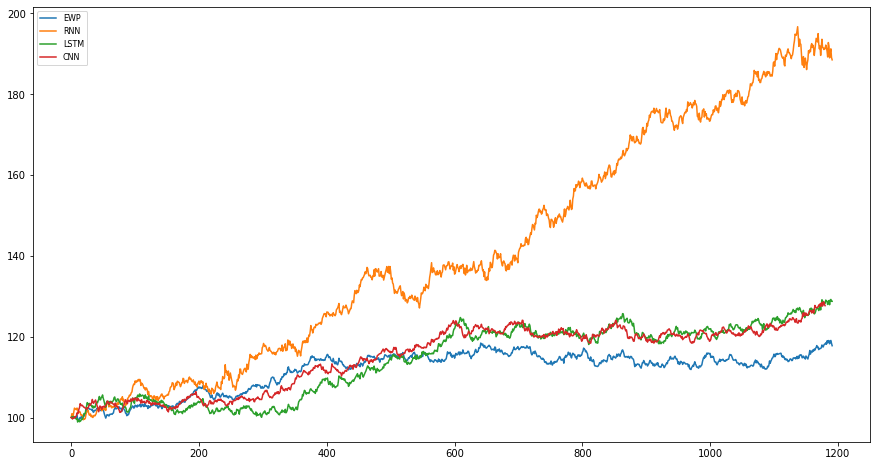

In [43]:
data = Data(seed=1, size=10, data_len=8000, n_past=10, train_size=0.8)
price_series, cov, expected_returns, actual_returns, mu = data.generate_data()
X_train, X_valid, X_test, y_train, y_valid, y_test = data.get_train_test_data(normalize=False)
X_train_valid, y_train_valid = data.get_train_valid()
unc_cov = data.calc_unconditional_cov()
ew_rets = y_test @ np.ones((10, 1))/10
rnn_trainer = RNNTrainer(rnn_space, data, opt='sortino', normalize=False, return_data=False)
rnn_model = rnn_trainer.get_model(rnn_space)
rnn_model.load_weights('Trained Models/RNN_not_sortino_19_13_18')
rnn_rets = get_model_rets(rnn_model, rnn_trainer.X_test, rnn_trainer.y_test)
lstm_trainer = LSTMTrainer(lstm_space, data, opt='sharpe', normalize=True, return_data=False)
lstm_model = lstm_trainer.get_model(lstm_space)
lstm_model.load_weights('Trained Models/LSTM_not_sharpe_Best')
lstm_rets = get_model_rets(lstm_model, lstm_trainer.X_test,lstm_trainer.y_test)
cnn_trainer = CNNTrainer(cnn_space,data, opt='sortino',normalize=False,return_data=True)
cnn_model = cnn_trainer.get_model(cnn_space)
cnn_model.load_weights('Trained Models/CNN_ret_sortino_19_11_49')
cnn_rets = get_model_rets(cnn_model, cnn_trainer.X_test, cnn_trainer.y_test)
fig, ax1 = plt.subplots(1, sharex=True, figsize=(15,8))
plot_pf(ew_rets,'EWP', ax1)
plot_pf(rnn_rets,'RNN', ax1)
plot_pf(lstm_rets,'LSTM', ax1)
plot_pf(cnn_rets,'CNN', ax1)
ax1.legend(loc='upper left', fontsize=8)

In [44]:
print(f'CNN Sharpe & Sortino: {sharpe(cnn_rets)}, {sortino(cnn_rets)}, {float(tf.reduce_prod(1 + cnn_rets) - 1)}')
print(f'RNN Sharpe & Sortino: {sharpe(rnn_rets)}, {sortino(rnn_rets)}, {float(tf.reduce_prod(1 + rnn_rets) - 1)}')
print(f'LSTM Sharpe & Sortino: {sharpe(lstm_rets)}, {sortino(lstm_rets)}, {float(tf.reduce_prod(1 + lstm_rets) - 1)}')
print(f'EW Sharpe & Sortino: {sharpe(ew_rets)}, {sortino(ew_rets)}, {float(tf.reduce_prod(1 + ew_rets) - 1)}')

CNN Sharpe & Sortino: 80.66631954383826, 138.774220937813, 0.2766723574464187
RNN Sharpe & Sortino: 147.1884263170373, 246.13410520594957, 0.8851711804605915
LSTM Sharpe & Sortino: 70.4070356978538, 120.88542733017971, 0.28755239273840716
EW Sharpe & Sortino: 52.91375689019119, 90.05942393566968, 0.1776538050083638


## Comparison of CNN and Markowitz

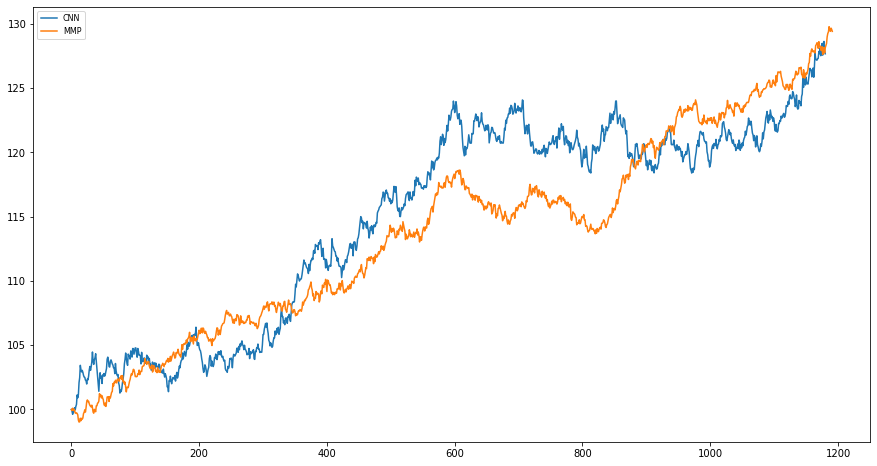

In [45]:
marko_rets = np.dot(y_test,x_opt(unc_cov,mu,np.dot(cnn_model.predict(cnn_trainer.X_test)[-1],mu)))
fig, ax1 = plt.subplots(1, sharex=True, figsize=(15,8))
plot_pf(cnn_rets,'CNN', ax1)
plot_pf(marko_rets,'MMP', ax1)
ax1.legend(loc='upper left', fontsize=8)

In [47]:
print(f'Markowitz Sharpe & Sortino: {sharpe(marko_rets)}, {sortino(marko_rets)}, {float(tf.reduce_prod(1 + marko_rets) - 1)}')

Markowitz Sharpe & Sortino: 127.07242193614817, 223.66805619668426, 0.29409987149967964


## Plot of the change in RNN allocations

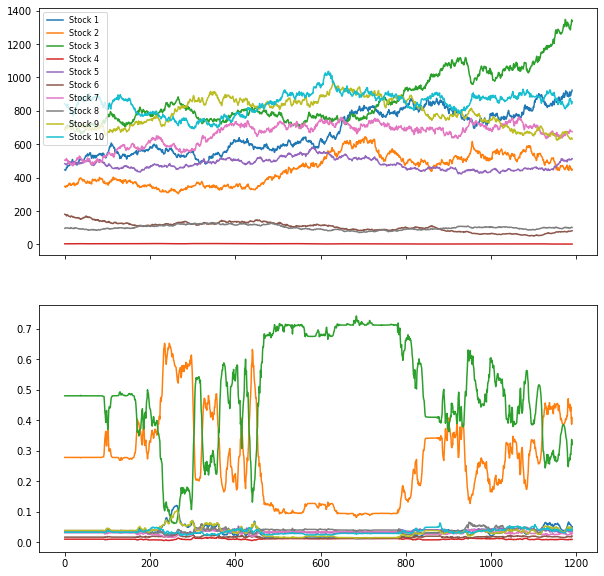

In [50]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True,figsize=(10,10))

preds = rnn_model.predict(X_test)
for i in range(preds.shape[1]):
    ax2.plot(preds[:,i],label=f'Stock {i+1}')

for i in range(X_test.shape[1]):
    ax1.plot(X_test[:, 0, i], label=f'Stock {i+1}')
ax1.legend(loc='upper left', fontsize=8)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9e2fe652-9345-434d-a8f2-b4c9fce078c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>